In [1]:
import pandas 
import numpy as np
import netCDF4 as nc
from scipy import stats
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
experiment="no_bias_correction"

In [2]:
def plot_point(ax,data,cmap,bounds,label_txt,colorbar=False,title=None):
    
    norm = mcolors.BoundaryNorm(bounds, cmap.N)#, extend='both')
    P = ax.scatter(lon,lat,s=3*nyrs, c=data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    #P = ax.scatter(lon,lat,s=10*nyrs, c=data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
    if nid == 0:
        ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
        ax.coastlines(zorder=55)
        
        # figure label 
        ax.text(0.05,0.9,plot_labels[nax], fontsize=20,transform=ax.transAxes)
        
        # ID label
        ax.text(.85,.7, label_txt, fontsize=20, transform=ax.transAxes,ha='center', va='center',zorder=60)
        #ax.text(.85,.85, label_txt, fontsize=20, transform=ax.transAxes,ha='center', va='center',zorder=60)
        
        plt.setp(ax.spines.values(), linewidth=2,zorder=100)
        
        if title:
            ax.set_title(title,fontsize=25, pad=15, ha='center', va='center')
            
    if (nid == len(np.unique(df.stationid))-1):
        ax.plot(x,y,color='k',transform=ccrs.PlateCarree())
        if (colorbar):
           
            pos = ax.get_position()
            cax = fig.add_axes([pos.x0+.03*pos.width, pos.y0+.01*pos.width, .4*pos.width, .08*pos.height])
            plt.setp(cax.spines.values(), linewidth=1.5,zorder=100)

            cbar = plt.colorbar(P,cax=cax,orientation='horizontal',ticks = bounds[::8])
            cbar.ax.xaxis.set_ticks_position('top')
            cbar.ax.tick_params(labelsize=15) 
        #if label_txt[0]=='R':
        #    cbar.ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.1f'))

In [3]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

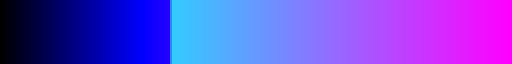

In [4]:
# colormaps
nrow=129
nrow2 = 2*nrow

# parts of different maps
colors2 = plt.cm.cool(np.linspace(.2, 1, nrow2))
colors3 = plt.cm.gnuplot2(np.linspace(0, .3, nrow))

# combine them and build a new colormap
colors = np.vstack((colors3, colors2))
cold_pool_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
cold_pool_map

In [5]:
shp_fil = '/work/role.medgrp/NEP/plotting/Figure_19_20/SEBS_shapefile.shp'
shapefile = gpd.read_file(shp_fil)
sebs_reproject_epsg = shapefile.copy()
sebs_reproject_epsg = sebs_reproject_epsg.to_crs(epsg=4269)
x,y = sebs_reproject_epsg.geometry[0].exterior.xy

/vftmp/Utheri.Wagura/pid3321330/ipykernel_3751003/1654285976.py:36: RuntimeWarning: Mean of empty slice
  nep_tob_mean = np.nanmean(nep_tob)
/vftmp/Utheri.Wagura/pid3321330/ipykernel_3751003/1654285976.py:38: RuntimeWarning: Mean of empty slice
  plot_point(ax1,np.nanmean(nep_tob_mean),cold_pool_map,np.linspace(-2,10,25),
/nbhome/role.medgrp/.conda/envs/medpy311/lib/python3.11/site-packages/pyproj/transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/vftmp/Utheri.Wagura/pid3321330/ipykernel_3751003/1654285976.py:49: RuntimeWarning: Mean of empty slice
  mean_bias = np.nanmean(nep_tob-trawl_temp)
/nbhome/role.medgrp/.conda/envs/medpy311/lib/python3.11/site-packages/pyproj/transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/vftmp/Utheri.Wagura/pid3321330/ipykernel_3751003/1654285976.py:55: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nan

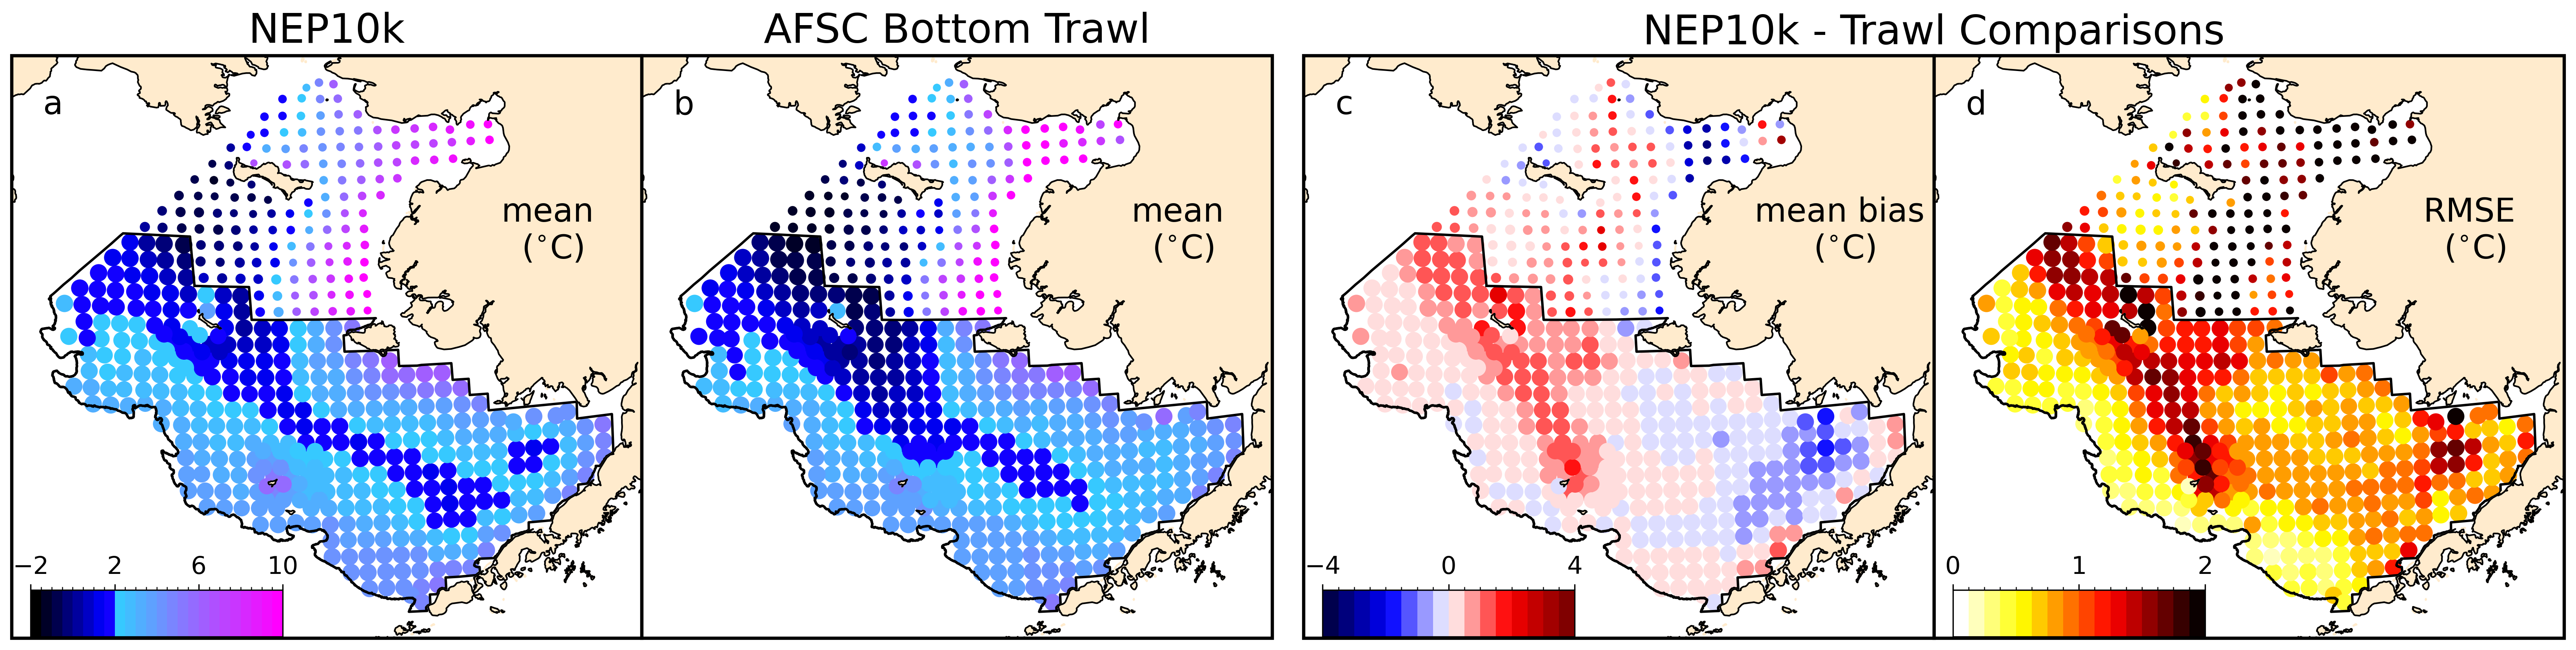

In [6]:
# Open csv file
csv_file = f'/work/Utheri.Wagura/NEP/plotting/Figure_19_20/{experiment}/ebs_nbs_temperature_full_area_nep.csv'
#csv_file = '/work/role.medgrp/NEP/plotting/Figure_19_20/ebs_nbs_temperature_full_area_nep.csv'
df = pandas.read_csv(csv_file)
df = df[df.year >= 1993].reset_index(drop=True)
#df = df[df.year <= 2019].reset_index(drop=True)
df = df[df.haul_type == 3].reset_index(drop=True)

# Figure details
widths = [10,10,.5,10,10]
fig = plt.figure(figsize=(28,7),dpi=300)
spec = fig.add_gridspec(ncols=5, nrows=1,wspace=0,hspace=0.,width_ratios=widths)  
ncol = 0    
plot_labels = ['a','b','c','d','e','f','g','h','i']

# allocating a bunch of map axes
ax1 = fig.add_subplot(spec[0,0], projection=ccrs.EquidistantConic(central_longitude=190,central_latitude=62))
ax2 = fig.add_subplot(spec[0,1], projection=ccrs.EquidistantConic(central_longitude=190,central_latitude=62))
ax3 = fig.add_subplot(spec[0,3], projection=ccrs.EquidistantConic(central_longitude=190,central_latitude=62))
ax4 = fig.add_subplot(spec[0,4], projection=ccrs.EquidistantConic(central_longitude=190,central_latitude=62))

# iterating over station IDs
nax=0
for station_id,nid in zip(np.unique(df.stationid),range(len(np.unique(df.stationid)))): 

    tmp_df = df[df['stationid']==station_id].reset_index(drop=True).sort_values(by=['year'])

    nyrs = len(tmp_df.year)
    lat = np.mean(tmp_df.latitude)
    lon = np.mean(tmp_df.longitude)
    
    trawl_temp = np.array(tmp_df.gear_temperature)
    nep_tob = np.array(tmp_df.nep_tob)
   
    # Mean NEP
    nep_tob_mean = np.nanmean(nep_tob)
    #print(nep_tob_mean)
    plot_point(ax1,np.nanmean(nep_tob_mean),cold_pool_map,np.linspace(-2,10,25),
               'mean\n ($^{\circ}$C)', colorbar=True,title='NEP10k')
    
    nax+=1
    # Mean Trawl
    trawl_temp_mean = np.mean(trawl_temp)
    #print(trawl_temp_mean)
    plot_point(ax2,trawl_temp_mean,cold_pool_map,np.linspace(-2,10,25),
               'mean\n ($^{\circ}$C)',title='AFSC Bottom Trawl')
    nax+=1
    # Mean Bias (NEP-Trawl)
    mean_bias = np.nanmean(nep_tob-trawl_temp)
    #print(mean_bias)
    plot_point(ax3,mean_bias,plt.cm.seismic,np.linspace(-4,4,17), 'mean bias\n ($^{\circ}$C)',colorbar=True)
    nax+=1

    # RMSE (NEP vs. Trawl)
    rmse = np.sqrt(np.nanmean((nep_tob-trawl_temp)**2))
    #print(rmse)
    plot_point(ax4,rmse,plt.cm.hot_r,np.linspace(0,2,17),'RMSE\n ($^{\circ}$C)',colorbar=True)
    nax+=1

ax3.text(1,1.02,'NEP10k - Trawl Comparisons',horizontalalignment='center',fontsize=25,transform=ax3.transAxes)        

plt.savefig(f'/work/Utheri.Wagura/NEP/plotting/Figure_19_20/{experiment}/Figure19_Bering_Cold_Pool_2D_Map')

In [7]:
#cpa_dir = '/work/role.medgrp/NEP/plotting/Figure_19_20/'
cpa_dir = f'/work/Utheri.Wagura/NEP/plotting/Figure_19_20/{experiment}/'

cpa_source_dict = {'trawl':{'label':'AFSC Trawl','file':'trawl_cpa.csv'},
                   'nep':{'label':'NEP10k','file':'nep_cpa.csv'},}

cpa_defs_dict = {'AREA_LTE2_KM2':{'color':"#21dae7",'label':r'≤ 2$^\circ$C'},
                 'AREA_LTE1_KM2':{'color':"#0071ff",'label':r'≤ 1$^\circ$C' },
                 'AREA_LTE0_KM2':{'color':"#0000e3",'label':r'≤ 0$^\circ$C' },
                 'AREA_LTEMINUS1_KM2':{'color':"#000040",'label':r'≤ -1$^\circ$C' }}

cpa_defs = ['AREA_LTE2_KM2','AREA_LTE1_KM2','AREA_LTE0_KM2','AREA_LTEMINUS1_KM2']

# Pulled from Rd code in coldpool package: sebs_layers$survey.area$AREA_KM2
survey_area = 493506.385108 #km2

trawl
nep


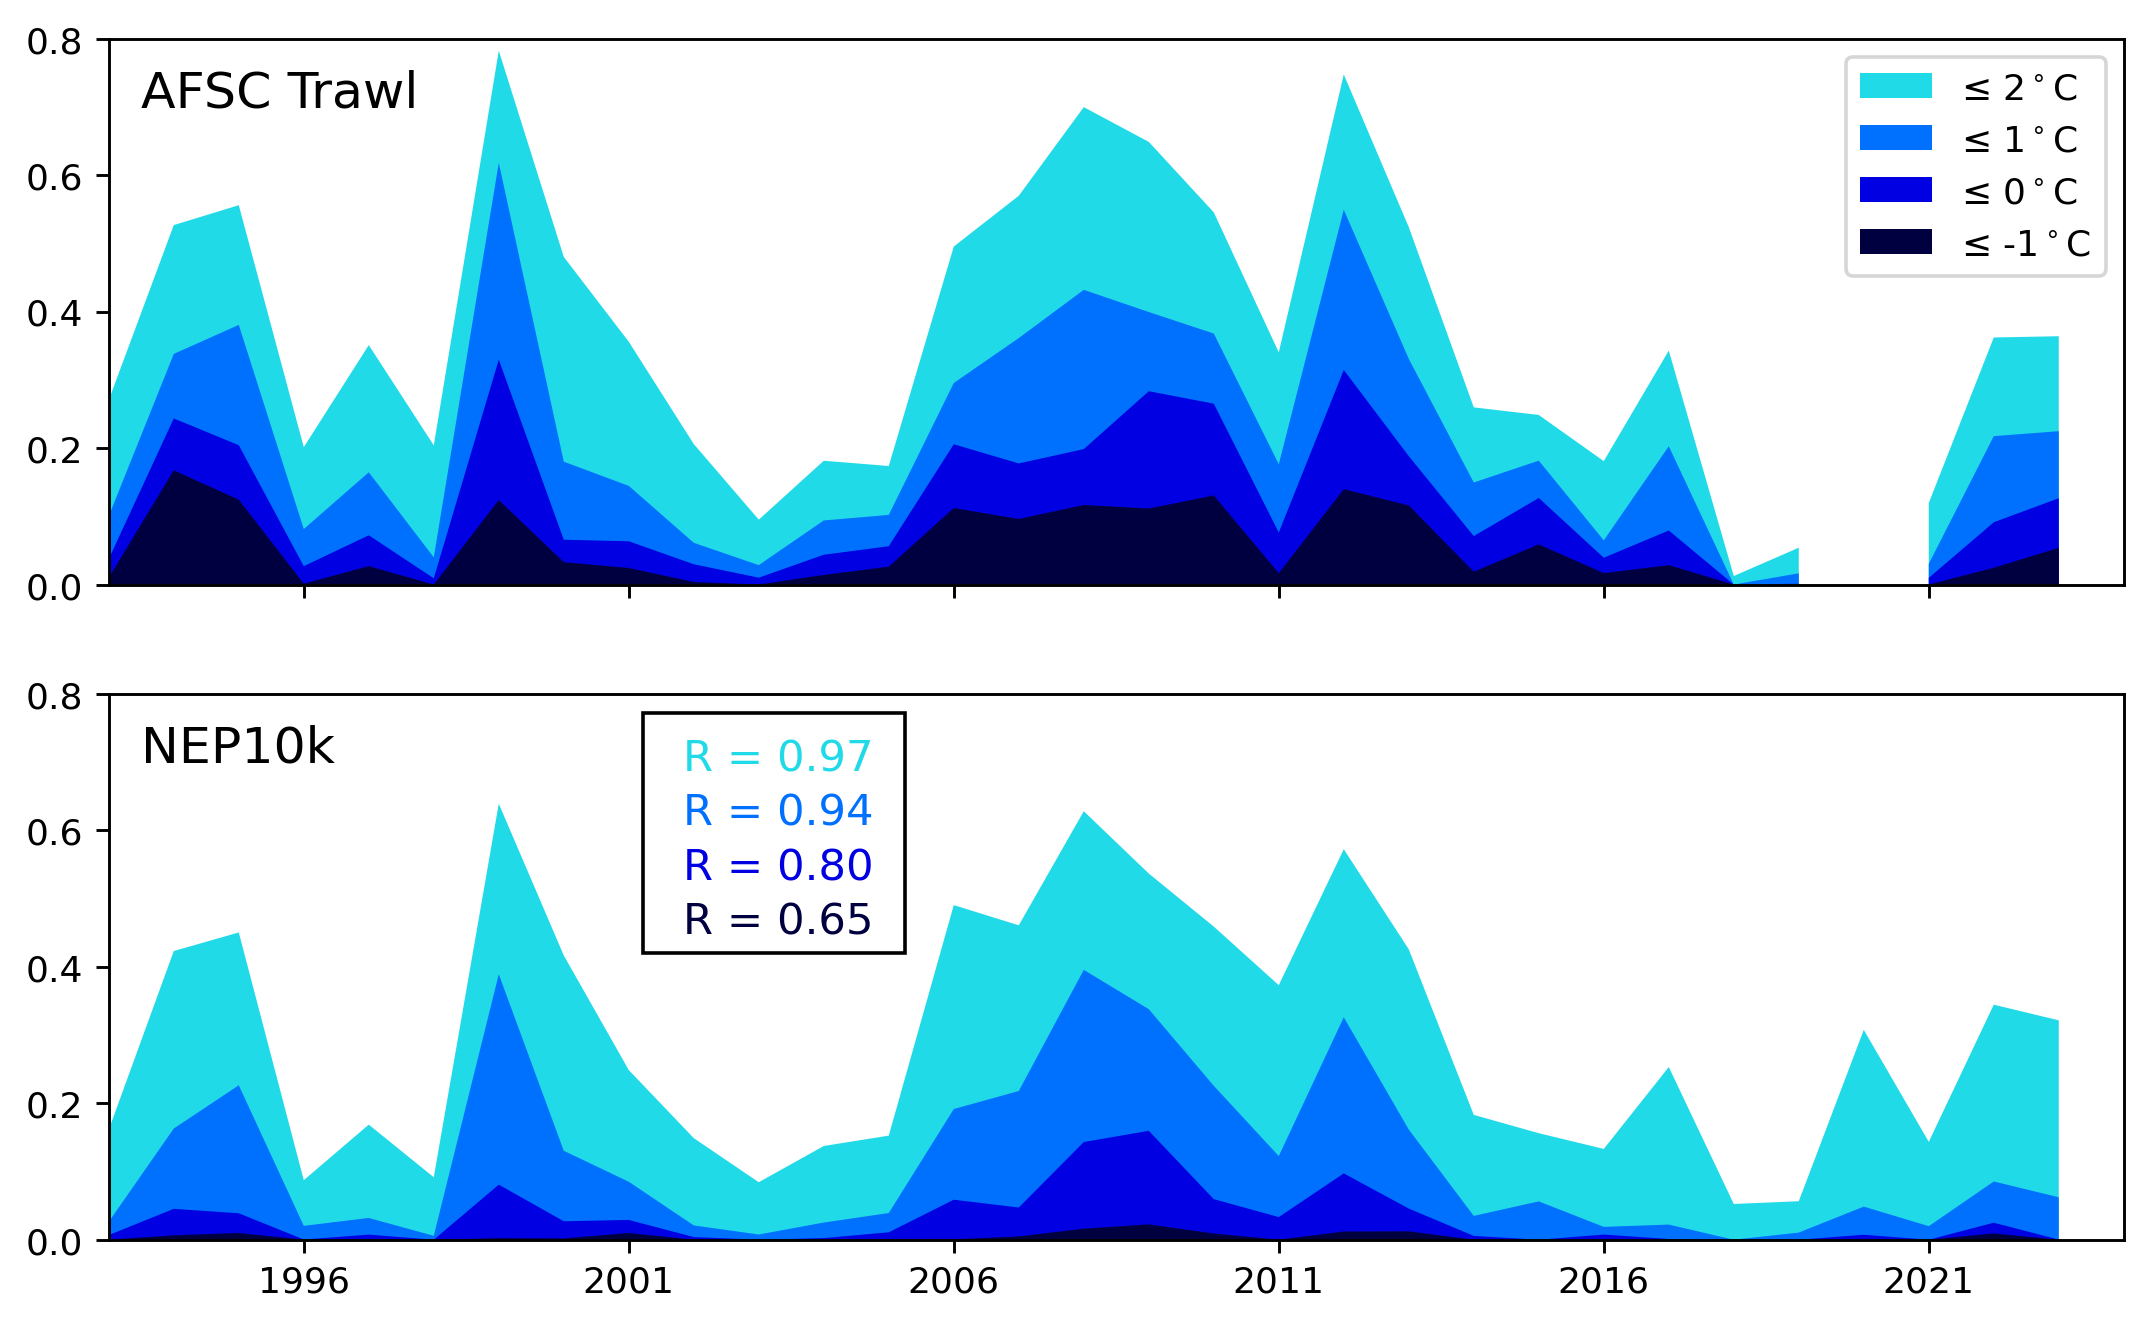

In [18]:
fig, axs = plt.subplots(2,figsize=(10,6),sharex=True,dpi=260)
#x = np.arange(1993,2024+1)
x = np.arange(1993,2024)

txt_x = 0.825
srcs = ['trawl','nep']
store_ts = np.zeros((len(cpa_defs),len(x)))
for src_nm,ns in zip(srcs,range(len(srcs))):
    print(src_nm)
    #csv_file = cpa_dir + src_nm + '/' + cpa_source_dict[src_nm]['file']
    csv_file = cpa_dir +  cpa_source_dict[src_nm]['file']
    df = pandas.read_csv(csv_file)
    
    # adding nans for 2020
    if src_nm == 'trawl':
       df1 = df[df.YEAR < 2020].reset_index(drop=True)
       df2 = pandas.DataFrame(np.append(2020,np.nan*np.ones(len(df.columns)-1))[np.newaxis,:], columns=df.columns)
       df3 = df[df.YEAR > 2020].reset_index(drop=True)
       df = pandas.concat([df1, df2, df3]).reset_index(drop=True)

    for cpa_def,ncpa in zip(cpa_defs,range(len(cpa_defs))):
        y = df[cpa_def]/survey_area
        #y = axs[ns].plot(df.YEAR,df[cpa_def],color=cpa_defs_dict[cpa_def]['color'])

        #if cpa_def == "AREA_LTEMINUS1_KM2" and src_nm == "nep":
        if src_nm == "nep":
            y = y[:-1]
        
        axs[ns].fill_between(x,0,y,
                             facecolor=cpa_defs_dict[cpa_def]['color'],
                             label= cpa_defs_dict[cpa_def]['label'])
        
        if ns == 0:
            store_ts[ncpa,:] = y
        else:
            y_trawl = store_ts[ncpa,:]
            y_nep = y
            nas = np.logical_or(np.isnan(y_trawl), np.isnan(y_nep))
            r_val = stats.pearsonr(y_trawl[~nas], y_nep[~nas])[0]
            
            txt = axs[ns].text(txt_x-.54, (.86- ncpa/10),'R = %.2f' % (r_val), color= cpa_defs_dict[cpa_def]['color'], 
                               fontsize=12, transform = axs[ns].transAxes, zorder=18)
           
    axs[ns].set_ylim(0,.8)
    axs[ns].text(1993.5,0.7,cpa_source_dict[src_nm]['label'],fontsize=14)
    
    if ns > 0:
        rect = mpatches.Rectangle((txt_x-.56, .525), .13, 0.44, linewidth=1, edgecolor='k', 
                                  facecolor='w',transform = axs[ns].transAxes,zorder=10)
        axs[ns].add_patch(rect)
    
axs[0].legend()    
axs[-1].set_xticks(np.arange(1996,2022+1,5))
axs[-1].set_xlim(1993,2024)

plt.savefig(f'/work/Utheri.Wagura/NEP/plotting/Figure_19_20/{experiment}/Figure20_trawl_vs_nep_coldpool_index.png')